In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')
    
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
model = ResNet18(alpha=1).to(device)

model.load_state_dict(torch.load('./pretrained/resnet18_cifar10_gvp_model_10.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

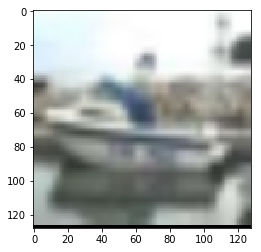

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = './test_img/cifar10/test.PNG'

img = Image.open(img_path)

plt.imshow(img)

In [6]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 32, 32)

tensor_img = Variable(tensor_img, requires_grad=True)

In [7]:
gradients = []

def save_gradient(grad):
    gradients.append(grad)
    
datas = Variable(tensor_img, requires_grad=True)

feature = datas[0].unsqueeze(0)

In [8]:
tensor_img.shape

torch.Size([1, 3, 32, 32])

In [ ]:
named_buffers(), named_children(), named_modules(), named_parameters()

In [61]:
for name, module in model._modules.items():
    #for name, module in module.named_children():
        #for name, module in module.named_children():
    print(name)

conv1
bn1
layer1
layer2
layer3
layer4
linear


In [9]:
for name, module in model.named_children():
    print(feature.shape)
    if name == 'dense1':
        feature = feature.view(feature.size(0), -1)
    feature = module(feature)
    if name == 'layer1':
        feature.register_hook(save_gradient)
        final_conv = feature
        print(feature.shape)
    if name == 'layer4':
        feature = torch.mean(feature, [2, 3])

torch.Size([1, 3, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512])


In [10]:
target = np.argmax(feature.cpu().data.numpy())
one_hot_output = torch.cuda.FloatTensor(1, feature.size()[-1]).zero_()
one_hot_output[0][target] = 1

In [11]:
class_name[target]

'ship'

In [12]:
feature.backward(gradient=one_hot_output, retain_graph=True)

In [13]:
gradients[0].shape

torch.Size([1, 64, 32, 32])

In [14]:
final_conv = final_conv.squeeze(0)

weight = gradients[0].mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
weights = torch.mean(gradients[0], [0,2,3]).cpu().numpy()

activations = final_conv.detach().cpu().numpy()

In [15]:
weight.shape, weights.shape

(torch.Size([1, 64, 1, 1]), (64,))

In [16]:
(weight[0] * final_conv).shape

torch.Size([64, 32, 32])

In [17]:
from torch.nn import functional as F

mask = F.relu((weight[0] * final_conv).sum(dim=0)).squeeze(0)
mask = mask.detach().cpu().numpy()

print(mask.shape)

(32, 32)


In [18]:
cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i,w in enumerate(weights):
    cam += w*activations[i,:,:]
    
print(cam)

[[ 2.3622676e-03  3.9006879e-03  3.8532636e-03 ...  2.4917456e-03
   2.3837625e-03  2.4629461e-03]
 [ 6.5379459e-03  6.9444189e-03  6.8523693e-03 ...  4.0523075e-03
   4.4061667e-03  3.7948221e-03]
 [ 7.3406505e-03  7.6287175e-03  7.4103125e-03 ...  4.4157491e-03
   5.4195905e-03  4.8302221e-03]
 ...
 [ 4.0761488e-03  3.9940965e-03  2.9308035e-03 ...  4.5758220e-03
   4.3921238e-03  2.4531367e-03]
 [ 4.8146774e-03  5.6546782e-03  5.1798644e-03 ...  6.2482245e-03
   5.1360563e-03  2.1151721e-03]
 [ 2.7053473e-03  1.5882942e-03  1.4562041e-03 ...  1.7284908e-03
   1.6957405e-05 -1.8876664e-03]]


In [19]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

In [20]:
cam = scaling(cam)
mask = scaling(mask)

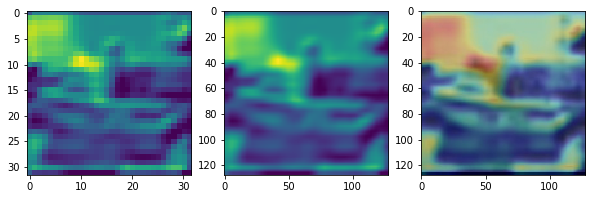

In [21]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(mask)

resized_cam = cv2.resize(mask, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.3 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)

Before: float32
After: uint8
number of contours: 7


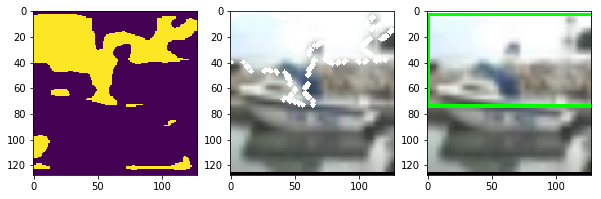

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))

threshold = 0.5

_, thresholded_heatmap = cv2.threshold(resized_cam, threshold * resized_cam.max(), 1, cv2.THRESH_BINARY)

axs[0].imshow(thresholded_heatmap)

print('Before:',thresholded_heatmap.dtype)
thresholded_heatmap = cv2.convertScaleAbs(thresholded_heatmap)
print('After:',thresholded_heatmap.dtype)

contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours:',len(contours))

contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))
    
# contour 면적이 큰 순서대로 정렬
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)

# # contour 면적이 큰 contours 선택
biggest_contour= sorted_contours[0][1]

# -1 : represent entire contours
# (255, 255, 255): color
# 3 : thinkness 
contour_image = cv2.drawContours(img.copy(), biggest_contour, -1, (255, 255, 255), 3)
axs[1].imshow(contour_image)

x,y,w,h = cv2.boundingRect(biggest_contour)
box_image = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255,0), 2)

axs[2].imshow(box_image)